# Task 2

### Integrantes
* Sergio Orellana 221122
* Rodrigo Mansilla 22611
* Ricardo Chuy 221007

El objetivo de esta parte es implementar el pipeline de alineación sin depender de cajas negras. Por ello considere que no deben de usar cv2.findHonography o cv2.RANSAC. Además para este laboratorio necesitara crear su propio dataset, por ello tome 3 fotografías propias de una escena planar (i.e. una pancarta en una pared, un cuadro, o una fachada de edificio lejana) con ángulos y perspectivas drásticamente diferentes.


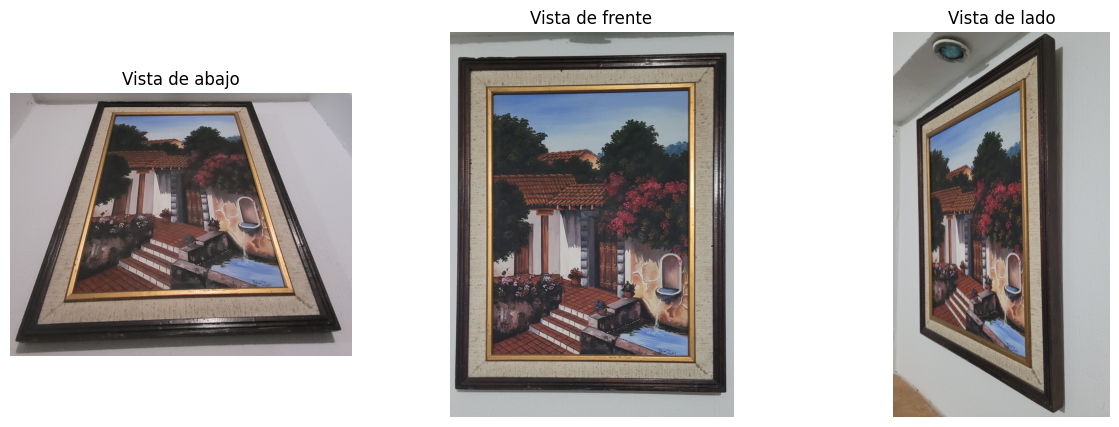

In [1]:
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

img1 = mpimg.imread('imgs/abajo.jpg')
img2 = mpimg.imread('imgs/frente.jpg')
img3 = mpimg.imread('imgs/lado.jpg')
# por algun motivo la imagegn 3 sale horizontalmente, entonces le di vuelta jej
img3 = np.rot90(img3, k=-1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

axes[0].imshow(img1)
axes[0].set_title('Vista de abajo')
axes[0].axis('off')  

axes[1].imshow(img2)
axes[1].set_title('Vista de frente')
axes[1].axis('off')

axes[2].imshow(img3)
axes[2].set_title('Vista de lado')
axes[2].axis('off')

# plt.tight_layout()  # Ajustar espaciado
plt.show()

## 1. Detección y Macheo
* a. Utilice SIFT u ORB (permitido usar OpenCV aquí) para detectar puntos de interés y descriptores.
* b. Realice un emparejamiento de fuerza bruta (Brute-Force Matcher).
* c. Requisito: Visualice los matches antes de filtrar. Debe verse una cantidad considerable de ruido/errores

### Parte a

In [ ]:
# parte a


# Rutas de tus archivos (según tu estructura de carpetas)
PATH_REF = 'imgs/frente.jpg'   # La imagen que es la meta
PATH_OBJ = 'imgs/abajo.jpg'     # La imagen que queremos enderezar

print(f"Referencia: {PATH_REF}\n Objetivo:   {PATH_OBJ}")

# 
img_ref_bgr = cv2.imread(PATH_REF)
img_obj_bgr = cv2.imread(PATH_OBJ)

# Validación simple
if img_ref_bgr is None or img_obj_bgr is None:
    raise ValueError("No se encontro la img")

img_ref_rgb = cv2.cvtColor(img_ref_bgr, cv2.COLOR_BGR2RGB)
img_obj_rgb = cv2.cvtColor(img_obj_bgr, cv2.COLOR_BGR2RGB)

img_ref_gray = cv2.cvtColor(img_ref_bgr, cv2.COLOR_BGR2GRAY)
img_obj_gray = cv2.cvtColor(img_obj_bgr, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()

# los keypoints y descriptores
kp_ref, des_ref = sift.detectAndCompute(img_ref_gray, None)
kp_obj, des_obj = sift.detectAndCompute(img_obj_gray, None)

print(f"Keypoints en Referencia: {len(kp_ref)}")
print(f"Keypoints en Objetivo:   {len(kp_obj)}")



Referencia: imgs/frente.jpg
 Objetivo:   imgs/abajo.jpg


### Parte b

In [ ]:
# Usamos Fuerza Bruta con distancia Euclidiana, el k=2 igual que en el lab pasado significa
# los 2 mejores matches
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches_crudos = matcher.knnMatch(des_ref, des_obj, k=2)

print(f"Matches Totales: {len(matches_crudos)}")

Matches Totales: 28311


### Parte c

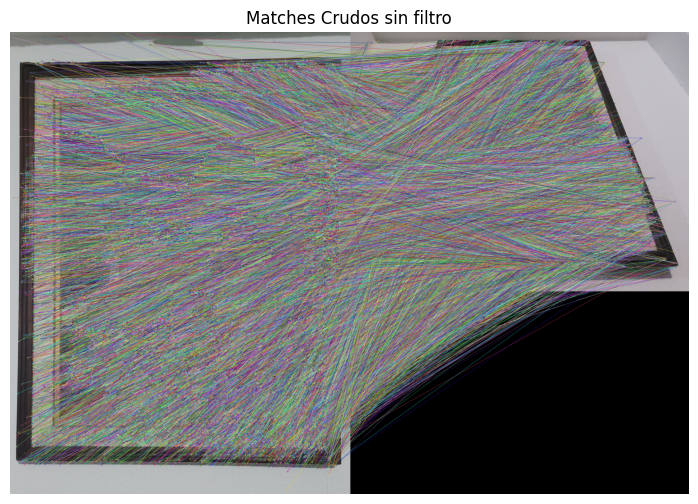

In [ ]:
matches_sin_filtro = [m for m, n in matches_crudos]

# Flags=0 dibuja todo. Flags=2 no dibuja puntos huerfanos.
img_ruido = cv2.drawMatches(
    img_ref_rgb, kp_ref, 
    img_obj_rgb, kp_obj, 
    matches_sin_filtro, # Pasamos la muestra ruidosa
    None, 
    flags=2
)

plt.figure(figsize=(15, 6))
plt.title("Matches Crudos sin filtro")
plt.imshow(img_ruido)
plt.axis('off')
plt.show()

Matches Totales: 28311
Matches Buenos: 1102


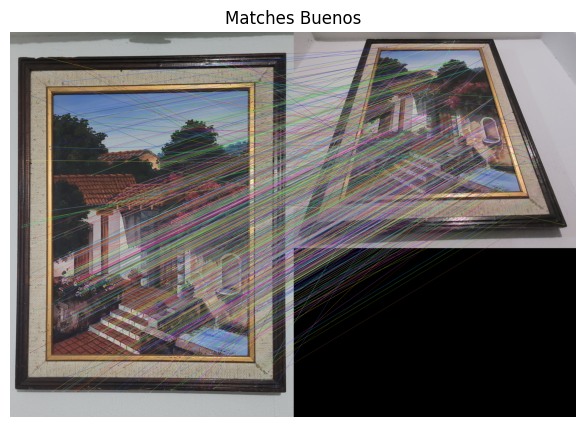

In [ ]:
# esto es algo extra que quisimos poner para verificar el match con filtro como el lab pasado

ratio = 0.75
matches_buenos = []

for m, n in matches_crudos:
    if m.distance < ratio * n.distance:
        matches_buenos.append(m)

print(f"Matches Totales: {len(matches_crudos)}")
print(f"Matches Buenos: {len(matches_buenos)}")

# visualizacion de los matches
img_matches = cv2.drawMatches(img_ref_rgb, kp_ref, img_obj_rgb, kp_obj, matches_buenos, None, flags=2)
plt.figure(figsize=(15, 5))
plt.title("Matches Buenos")
plt.imshow(img_matches)
plt.axis('off')
plt.show()


## 2. Algoritmo DLT
a. Escriba una función calcular_homografia_dlt(puntos_src, puntos_dst) que
reciba exactamente 4 pares de puntos.

b. Debe construir la matriz A de tamaño 8×9.

c. Debe resolver el sistema usando SVD (numpy.linalg.svd).

d. Nota: Debe normalizar los puntos antes de entrar al DLT (restar la media y dividir por la desviación estándar) para estabilidad numérica, y des-normalizar la matriz H resultante.

### Función de Homografía

In [ ]:
def normalizar_puntos(puntos, eps=1e-12):
    puntos = np.asarray(puntos, dtype=np.float64)
    if puntos.ndim != 2 or puntos.shape[1] != 2:
        raise ValueError("puntos debe tener forma (N,2)")

    mu = np.mean(puntos, axis=0)
    sigma = np.std(puntos, axis=0)
    sigma[sigma < eps] = 1.0  

    T = np.array([
        [1.0/sigma[0], 0.0, -mu[0]/sigma[0]],
        [0.0, 1.0/sigma[1], -mu[1]/sigma[1]],
        [0.0, 0.0, 1.0]
    ], dtype=np.float64)

    pts_h = np.hstack([puntos, np.ones((puntos.shape[0], 1))])
    pts_n = (T @ pts_h.T).T
    return pts_n[:, :2], T

def calcular_homografia_dlt(puntos_src, puntos_dst, eps=1e-12):
    src = np.asarray(puntos_src, dtype=np.float64)
    dst = np.asarray(puntos_dst, dtype=np.float64)
    
    if src.shape[0] < 4 or dst.shape[0] < 4:
        raise ValueError("Se requieren al menos 4 pares de puntos.")
    if src.shape[0] != dst.shape[0] or src.shape[1] != 2 or dst.shape[1] != 2:
        raise ValueError("src y dst deben tener forma (N,2) con el mismo N.")


    src_n, T_src = normalizar_puntos(src)
    dst_n, T_dst = normalizar_puntos(dst)

    A = []
    for (x, y), (xp, yp) in zip(src_n, dst_n):
        A.append([-x, -y, -1,  0,  0,  0, x*xp, y*xp, xp])
        A.append([ 0,  0,  0, -x, -y, -1, x*yp, y*yp, yp])

    A = np.asarray(A, dtype=np.float64)
    _, _, Vt = np.linalg.svd(A)
    Hn = Vt[-1].reshape(3, 3)

    H = np.linalg.inv(T_dst) @ Hn @ T_src
    if abs(H[2, 2]) < eps:
        return H
    return H / H[2, 2]


### 3. RANSAC Manual
a. Implemente la función ransac_homografia(matches, umbral, prob_exito).

b. Cálculo de N: Su código debe calcular dinámicamente el número de iteraciones N basado
en la fórmula de probabilidad vista en clase. No "hardcodee" el número 1000.

c. Bucle:
    i. Seleccione 4 matches aleatorios.
    ii. Llame a su función DLT.
    iii. Proyecte todos los puntos fuente usando H_test.
    iv. Calcule el error de reproyección (distancia Euclidiana) y cuente los inliers.

a. Refinamiento: Una vez encontrado el mejor conjunto de inliers, recalcule 𝐻 final usando todos los inliers (no solo los 4 iniciales) mediante SVD


In [ ]:
def ransac_homografia(matches, kp_src, kp_dst, umbral, prob_exito=0.99):
    src_pts = np.array([kp_src[m.queryIdx].pt for m in matches])
    dst_pts = np.array([kp_dst[m.trainIdx].pt for m in matches])
    num_matches = len(matches)

    s = 4               # puntos por muestra
    w = 0.5             # estimación inicial de ratio de inliers
    # Calcular N inicial con la fórmula:
    # N = log(1 - p) / log(1 - w^s)
    N = int(np.ceil(np.log(1 - prob_exito) / np.log(1 - w**s))) if w < 1 else 1

    mejor_H = None
    mejor_inliers = []
    iteracion = 0

    # --- BLOQUE 3: Loop principal ---
    while iteracion < N:
        if num_matches < 4:
            break
        idx = np.random.choice(num_matches, size=4, replace=False)
        
        src_4 = src_pts[idx]
        dst_4 = dst_pts[idx]

        try:
            H_test = calcular_homografia_dlt(src_4, dst_4)
        except:
            iteracion += 1
            continue

        pts_h = np.hstack([src_pts, np.ones((num_matches, 1))])  
        proj_h = (H_test @ pts_h.T).T  # (N,3)
        proj = proj_h[:, :2] / proj_h[:, 2:3]

        errores = np.linalg.norm(proj - dst_pts, axis=1)

        inliers = np.where(errores < umbral)[0]

        if len(inliers) > len(mejor_inliers):
            mejor_inliers = inliers
            mejor_H = H_test

            # Actualizar w y recalcular N
            w = len(inliers) / num_matches
            if w == 1:
                N = 1
            else:
                N = int(np.ceil(np.log(1 - prob_exito) / np.log(1 - w**s)))

        iteracion += 1

    if len(mejor_inliers) >= 4:
        H_final = calcular_homografia_dlt(
            src_pts[mejor_inliers],
            dst_pts[mejor_inliers]
        )
    else:
        H_final = mejor_H

    print(f"Inliers: {len(mejor_inliers)} / {num_matches}")
    print(f"Iteraciones: {iteracion}")
    return H_final, mejor_inliers


#### Salida

Inliers: 840 / 1102
Iteraciones: 12
Homografía encontrada:
[[ 4.85475196e-01 -2.01572948e-01  5.67839401e+02]
 [ 4.58360259e-03  2.57445744e-01  5.80614038e+00]
 [ 1.80759584e-05 -1.93085770e-04  1.00000000e+00]]


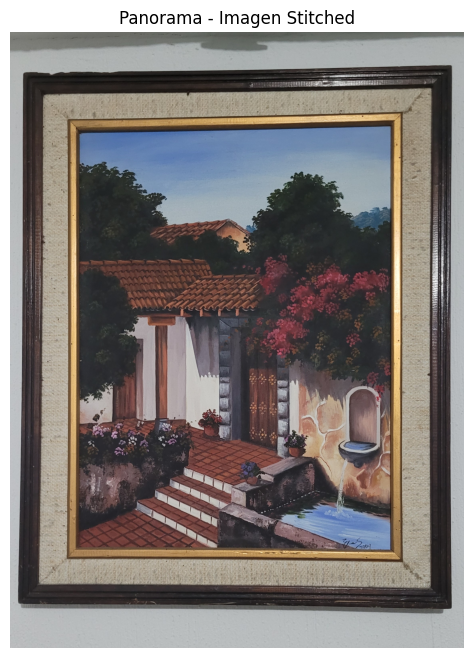

In [ ]:
H_final, inliers = ransac_homografia(
    matches_buenos, kp_ref, kp_obj, 
    umbral=5.0, 
    prob_exito=0.99
)

print("Homografía encontrada:")
print(H_final)

h_ref, w_ref = img_ref_rgb.shape[:2]
h_obj, w_obj = img_obj_rgb.shape[:2]

# Proyectar las esquinas de la imagen objetivo 
esquinas_obj = np.array([
    [0, 0],
    [w_obj, 0],
    [w_obj, h_obj],
    [0, h_obj]
], dtype=np.float64)

esquinas_h = np.hstack([esquinas_obj, np.ones((4, 1))])
esquinas_proj = (H_final @ esquinas_h.T).T
esquinas_proj = esquinas_proj[:, :2] / esquinas_proj[:, 2:3]

todas_esquinas = np.vstack([
    esquinas_proj,
    [[0, 0], [w_ref, 0], [w_ref, h_ref], [0, h_ref]]
])

x_min, y_min = todas_esquinas.min(axis=0).astype(int)
x_max, y_max = todas_esquinas.max(axis=0).astype(int)

T_traslacion = np.array([
    [1, 0, -x_min],
    [0, 1, -y_min],
    [0, 0, 1]
], dtype=np.float64)

ancho_canvas = x_max - x_min
alto_canvas = y_max - y_min

# ===== 1. Warp de la imagen objetivo (vista de abajo → corregida) =====
img_warp_obj = cv2.warpPerspective(
    img_obj_rgb, 
    T_traslacion @ H_final, 
    (ancho_canvas, alto_canvas)
)

# ===== 2. Colocar referencia en canvas =====
img_warp_ref = np.zeros_like(img_warp_obj)
img_warp_ref[-y_min:-y_min + h_ref, -x_min:-x_min + w_ref] = img_ref_rgb

# ===== 3. Blending: promediar donde ambas tienen píxeles =====
mask_obj = (img_warp_obj.sum(axis=2) > 0).astype(np.float64)
mask_ref = (img_warp_ref.sum(axis=2) > 0).astype(np.float64)

mask_obj_3 = np.stack([mask_obj]*3, axis=2)
mask_ref_3 = np.stack([mask_ref]*3, axis=2)

total = mask_obj_3 + mask_ref_3
total[total == 0] = 1.0  # evitar división por cero

panorama = (img_warp_obj.astype(np.float64) * mask_obj_3 + 
            img_warp_ref.astype(np.float64) * mask_ref_3) / total
panorama = np.clip(panorama, 0, 255).astype(np.uint8)

# ===== 4. Visualización =====
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Original de abajo
axes[0, 0].imshow(img_obj_rgb)
axes[0, 0].set_title("Original: Vista de abajo")
axes[0, 0].axis('off')

# Referencia frontal
axes[0, 1].imshow(img_ref_rgb)
axes[0, 1].set_title("Referencia: Vista frontal")
axes[0, 1].axis('off')

# Warp solo (corrección de perspectiva)
axes[1, 0].imshow(img_warp_obj)
axes[1, 0].set_title("Imagen de abajo warpeada (corregida)")
axes[1, 0].axis('off')

# Panorama con blending
axes[1, 1].imshow(panorama)
axes[1, 1].set_title("Panorama Stitched (con blending)")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()